In [1]:
import sys
import os
from glob import glob
import pickle
import os
import urllib
from functools import reduce
from collections import deque
import collections
import gc

from joblib import Parallel, delayed

from tqdm import tqdm

import numpy as np
import numpy.typing as npt

import json

import numba
from numba import types

import pandas as pd

import scipy.optimize
from scipy.ndimage import label

import cv2

from scipy.ndimage import convolve

from PIL import Image
from PIL import ImageEnhance

import matplotlib.pyplot as plt
from matplotlib import patches

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms.functional as TF

sys.path.insert(0, os.getcwd())

from config import Config
config = Config(data_directory=r"D:\RecodAI\recodai-luc-scientific-image-forgery-detection")
config.DINOV3_DEVICE = torch.device("cpu")

from DinoV3_Train import seg_model, \
                            checkpoint_path, \
                            resize_image_to_fit_patch
                            
seg_model.to(config.DINOV3_DEVICE)

# Load checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DINOV3_DEVICE)
    seg_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from {checkpoint_path}")
else:
    print(f"No checkpoint found at {checkpoint_path}, using untrained model")


Loaded checkpoint from weights\dinov3_vits16_dinov3_S_FT.pth


In [2]:
class ParticipantVisibleError(Exception):
    pass

@numba.jit(nopython=True)
def _rle_encode_jit(x: npt.NDArray, fg_val: int = 1) -> list[int]:
    """Numba-jitted RLE encoder."""
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_encode(masks: list[npt.NDArray], fg_val: int = 1) -> str:
    """
    Adapted from contrails RLE https://www.kaggle.com/code/inversion/contrails-rle-submission
    Args:
        masks: list of numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encodings as a string, with each RLE JSON-encoded and separated by a semicolon.
    """
    return ';'.join([json.dumps(_rle_encode_jit(x, fg_val)) for x in masks])

@numba.njit
def _rle_decode_jit(mask_rle: npt.NDArray, height: int, width: int) -> npt.NDArray:
    """
    s: numpy array of run-length encoding pairs (start, length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if len(mask_rle) % 2 != 0:
        # Numba requires raising a standard exception.
        raise ValueError('One or more rows has an odd number of values.')

    starts, lengths = mask_rle[0::2], mask_rle[1::2]
    starts -= 1
    ends = starts + lengths
    for i in range(len(starts) - 1):
        if ends[i] > starts[i + 1]:
            raise ValueError('Pixels must not be overlapping.')
    img = np.zeros(height * width, dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img

def rle_decode(mask_rle: str, shape: tuple[int, int]) -> npt.NDArray:
    """
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """

    mask_rle = json.loads(mask_rle)
    mask_rle = np.asarray(mask_rle, dtype=np.int32)
    starts = mask_rle[0::2]
    if sorted(starts) != list(starts):
        raise ParticipantVisibleError('Submitted values must be in ascending order.')
    try:
        return _rle_decode_jit(mask_rle, shape[0], shape[1]).reshape(shape, order='F')
    except ValueError as e:
        raise ParticipantVisibleError(str(e)) from e

def calculate_f1_score(pred_mask: npt.NDArray, gt_mask: npt.NDArray):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    tp = np.sum((pred_flat == 1) & (gt_flat == 1))
    fp = np.sum((pred_flat == 1) & (gt_flat == 0))
    fn = np.sum((pred_flat == 0) & (gt_flat == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0

def calculate_f1_matrix(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Parameters:
    pred_masks (np.ndarray):
            First dimension is the number of predicted instances.
            Each instance is a binary mask of shape (height, width).
    gt_masks (np.ndarray):
            First dimension is the number of ground truth instances.
            Each instance is a binary mask of shape (height, width).
    """

    num_instances_pred = len(pred_masks)
    num_instances_gt = len(gt_masks)
    f1_matrix = np.zeros((num_instances_pred, num_instances_gt))

    # Calculate F1 scores for each pair of predicted and ground truth masks
    for i in range(num_instances_pred):
        for j in range(num_instances_gt):
            pred_flat = pred_masks[i].flatten()
            gt_flat = gt_masks[j].flatten()
            f1_matrix[i, j] = calculate_f1_score(pred_mask=pred_flat, gt_mask=gt_flat)

    if f1_matrix.shape[0] < len(gt_masks):
        # Add a row of zeros to the matrix if the number of predicted instances is less than ground truth instances
        f1_matrix = np.vstack((f1_matrix, np.zeros((len(gt_masks) - len(f1_matrix), num_instances_gt))))

    return f1_matrix

def oF1_score(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Calculate the optimal F1 score for a set of predicted masks against
    ground truth masks which considers the optimal F1 score matching.
    This function uses the Hungarian algorithm to find the optimal assignment
    of predicted masks to ground truth masks based on the F1 score matrix.
    If the number of predicted masks is less than the number of ground truth masks,
    it will add a row of zeros to the F1 score matrix to ensure that the dimensions match.

    Parameters:
    pred_masks (list of np.ndarray): List of predicted binary masks.
    gt_masks (np.ndarray): Array of ground truth binary masks.
    Returns:
    float: Optimal F1 score.
    """
    f1_matrix = calculate_f1_matrix(pred_masks, gt_masks)

    # Find the best matching between predicted and ground truth masks
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    # The linear_sum_assignment discards excess predictions so we need a separate penalty.
    excess_predictions_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_predictions_penalty

def evaluate_single_image(label_rles: str, prediction_rles: str, shape_str: str) -> float:
    shape = json.loads(shape_str)
    label_rles = [rle_decode(x, shape=shape) for x in label_rles.split(';')]
    prediction_rles = [rle_decode(x, shape=shape) for x in prediction_rles.split(';')]
    return oF1_score(prediction_rles, label_rles)

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Args:
        solution (pd.DataFrame): The ground truth DataFrame.
        submission (pd.DataFrame): The submission DataFrame.
        row_id_column_name (str): The name of the column containing row IDs.
    Returns:
        float

    Examples
    --------
    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 103]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.9983739837398374

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102];[300, 100]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.8333333333333334
    """
    df = solution
    df = df.rename(columns={'annotation': 'label'})

    df['prediction'] = submission['annotation']
    # Check for correct 'authentic' label
    authentic_indices = (df['label'] == 'authentic') | (df['prediction'] == 'authentic')
    df['image_score'] = ((df['label'] == df['prediction']) & authentic_indices).astype(float)

    df.loc[~authentic_indices, 'image_score'] = df.loc[~authentic_indices].apply(
        lambda row: evaluate_single_image(row['label'], row['prediction'], row['shape']), axis=1
    )
    return float(np.mean(df['image_score']))


In [3]:
# Override thresholds
MASK_THRESHOLD = 0.70
SIFT_THRESHOLD = 0.75
IOU_THRESHOLD = 0.1

def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IOU) of two bounding boxes.
    
    Args:
        box1: tuple (min_x, min_y, max_x, max_y)
        box2: tuple (min_x, min_y, max_x, max_y)
        
    Returns:
        iou: float
    """
    x1, y1, x2, y2 = box1
    x1b, y1b, x2b, y2b = box2
    inter_x1 = max(x1, x1b)
    inter_y1 = max(y1, y1b)
    inter_x2 = min(x2, x2b)
    inter_y2 = min(y2, y2b)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x2b - x1b) * (y2b - y1b)
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0

def extract_objects(img, mask):
    """
    Extract objects from the image based on the boolean mask.
    Each connected component in the mask is cropped from the image.
    
    Args:
        img: PIL Image (RGB)
        mask: numpy array (H, W) boolean
        
    Returns:
        objects: dict where key is bounding box (min_col, min_row, max_col, max_row), value is cropped RGB image numpy array
    """
    img_np = np.array(img)
    labeled_mask, num_features = label(mask)
    objects = {}
    for i in range(1, num_features + 1):
        component_mask = labeled_mask == i
        rows, cols = np.where(component_mask)
        min_row, max_row = rows.min(), rows.max()
        min_col, max_col = cols.min(), cols.max()
        cropped = img_np[min_row:max_row+1, min_col:max_col+1]
        objects[(min_col, min_row, max_col, max_row)] = cropped
    return objects

def find_objects_with_sift(extracted_objects, image, threshold=SIFT_THRESHOLD):
    """
    Use SIFT to find the extracted objects in the given image.
    
    Args:
        extracted_objects: dict where key is bounding box (min_col, min_row, max_col, max_row), value is numpy array (RGB image of object)
        image: PIL Image (RGB)
        threshold: float, ratio threshold for matching (default 0.75)
        
    Returns:
        results: dict where key is bounding box from extracted_objects, value is found bounding box (min_x, min_y, max_x, max_y) in image or None if not found
    """
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    sift = cv2.SIFT_create()
    results = {}
    for bbox, obj in extracted_objects.items():
        obj_cv = cv2.cvtColor(obj, cv2.COLOR_RGB2BGR)
        kp1, des1 = sift.detectAndCompute(obj_cv, None)
        kp2, des2 = sift.detectAndCompute(image_cv, None)
        if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
            results[bbox] = None
            continue
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)
        good = []
        for m, n in matches:
            if m.distance < threshold * n.distance:
                good.append(m)
        if len(good) > 10:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            if M is None or M.shape != (3, 3):
                results[bbox] = None
                continue
            # Compute bounding box in image
            h, w = obj.shape[:2]
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
            transformed = cv2.perspectiveTransform(corners, M)
            x_coords = transformed[:, 0, 0]
            y_coords = transformed[:, 0, 1]
            min_x, max_x = x_coords.min(), x_coords.max()
            min_y, max_y = y_coords.min(), y_coords.max()
            found_bbox = (min_x, min_y, max_x, max_y)
            results[bbox] = found_bbox
        else:
            results[bbox] = None
    return results

def probability_to_boolean_mask(prob_mask, threshold=MASK_THRESHOLD):
    """
    Convert a probability mask to a boolean mask based on a threshold.
    
    Args:
        prob_mask: numpy array (H, W) with values in [0, 1]
        threshold: float, threshold value for binarization
        
    Returns:
        bool_mask: numpy array (H, W) of boolean type
    """
    return prob_mask > threshold

def convert_to_probability_mask(pred_mask):
    """
    Convert the output of infer_segmentation (logits) to a probability mask with values in [0, 1].
    
    Args:
        pred_mask: numpy array (H, W) output from infer_segmentation
        
    Returns:
        prob_mask: numpy array (H, W) with values in [0, 1]
    """
    return torch.sigmoid(torch.from_numpy(pred_mask)).numpy()

def infer_segmentation(img):
    """
    Perform segmentation inference on a single image.
    
    Args:
        image_path: Path to the input image
        
    Returns:
        pred_mask: Predicted mask as numpy array (H, W)
    """
    # Load and preprocess image
    img_resized = resize_image_to_fit_patch(img)
    img_np = np.array(img_resized)
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img_np) \
                        .permute(2, 0, 1) \
                        .float() \
                        .div(255.0) \
                        .unsqueeze(0) \
                        .to(config.DINOV3_DEVICE)
                        
    img_tensor = TF.normalize(img_tensor, mean=config.DINOV3_IMAGENET_MEAN, std=config.DINOV3_IMAGENET_STD)
    
    # Inference
    with torch.no_grad():
        pred_mask = seg_model(img_tensor)  # (1, 1, H, W)
        pred_mask = pred_mask.squeeze(0).squeeze(0).cpu().numpy()  # (H, W)
    
    prob_mask = convert_to_probability_mask(pred_mask)
    
    return prob_mask

def smooth_boolean_mask_positive(mask, kernel_size=3):
    """
    Smooth boolean mask: a pixel becomes True only if a strict majority of its neighbors
    (excluding itself) are True; otherwise it keeps its original value.

    Uses int32 accumulator to prevent overflow when kernel_size grows.
    """
    if kernel_size % 2 == 0 or kernel_size < 3:
        raise ValueError("kernel_size must be an odd integer >= 3")

    # Use int32 to avoid overflow
    mask = mask.astype(np.int32)
    
    kernel = np.ones((kernel_size, kernel_size), dtype=np.int32)

    # Convolve to get sum including center
    neighbor_sum_incl = convolve(mask, kernel, mode='constant', cval=0)

    # Sum of neighbors only (exclude the center pixel)
    neighbors_sum = neighbor_sum_incl - mask

    # Number of neighbors (excluding center)
    n_neighbors = kernel_size * kernel_size - 1

    # Strict majority threshold: more than half of neighbors being True
    majority_threshold = n_neighbors // 2

    # New mask: keep original value unless strict majority of neighbors are True -> set True
    new_mask = mask.copy().astype(bool)
    majority_true = neighbors_sum > majority_threshold
    new_mask[majority_true] = True

    return new_mask

def subtract_mask_from_image(img, mask):
    """
    Subtract the boolean mask from the RGB image by masking out the regions where mask is True.
    
    Args:
        img: PIL Image (RGB)
        mask: numpy array (H, W) boolean
        
    Returns:
        masked_img: PIL Image (RGB) with masked regions set to black
    """
    img_np = np.array(img)
    mask_np = mask.astype(np.uint8)
    # Mask out: set pixels where mask is True to 0
    masked_np = img_np * (1 - mask_np[:, :, None])
    return Image.fromarray(masked_np.astype(np.uint8))

def upscale_mask(pred_mask, img, method='linear'):
    """
    Upscale the predicted mask to the original image size using anti-aliasing.
    
    Args:
        pred_mask: numpy array (H, W) predicted mask
        original_image_path: path to original image
        method: 'linear' or 'nearest' interpolation method
        
    Returns:
        upscaled_mask: numpy array resized to original image dimensions
    """
    # Get original image size
    original_size = img.size  # (width, height)
    
    # Convert mask to PIL Image
    mask_img = Image.fromarray((pred_mask * 255).astype(np.uint8), mode='L')
    
    # Resize with anti-aliasing
    if method == 'linear':
        # Use bilinear interpolation with anti-aliasing
        upscaled_img = mask_img.resize(original_size, resample=Image.Resampling.BILINEAR)
    elif method == 'nearest':
        # Use nearest neighbor (no anti-aliasing)
        upscaled_img = mask_img.resize(original_size, resample=Image.Resampling.NEAREST)
    else:
        raise ValueError("Method must be 'linear' or 'nearest'")
    
    # Convert back to numpy array and normalize to [0, 1]
    upscaled_mask = np.array(upscaled_img).astype(np.float32) / 255.0
    
    upscaled_mask = convert_to_probability_mask(upscaled_mask)
    upscaled_mask = probability_to_boolean_mask(upscaled_mask)
    
    return upscaled_mask


In [4]:
forged_folder = os.path.join(config.data_directory, 'test_images')
authentic_folder = os.path.join(config.data_directory, 'train_images', 'authentic')
mask_folder = os.path.join(config.data_directory, 'train_masks')

C:\Users\vishn\AppData\Local\Temp\ipykernel_20796\2573418758.py:227: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_img = Image.fromarray((pred_mask * 255).astype(np.uint8), mode='L')


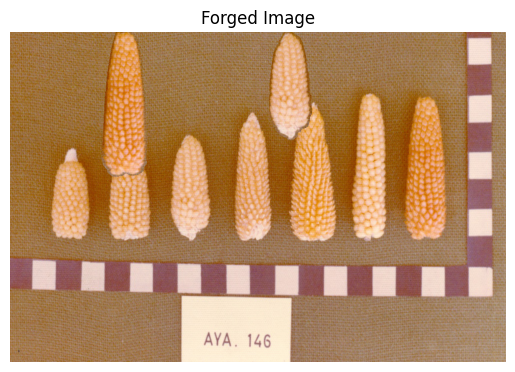

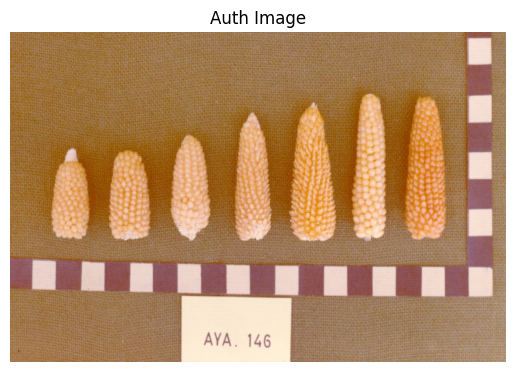

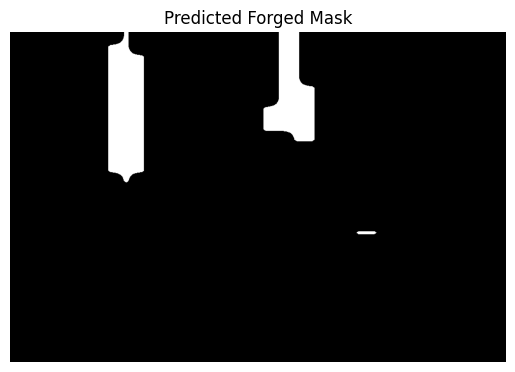

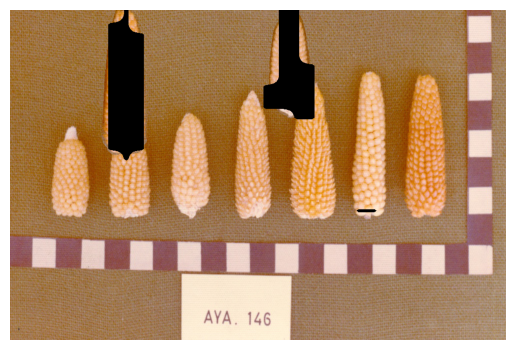

Extracted 3 objects from the forged image.
Found 2 objects in the forged image using SIFT.


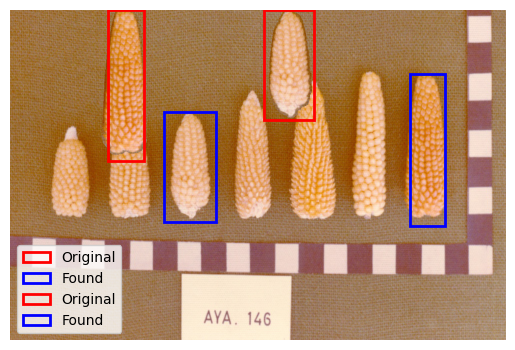

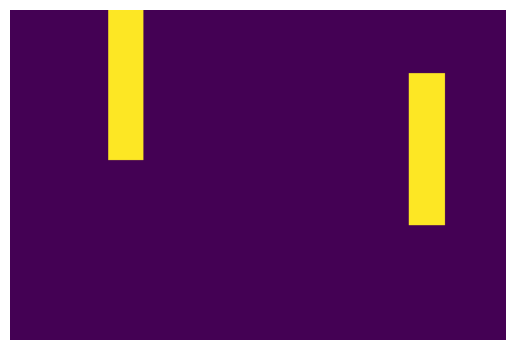

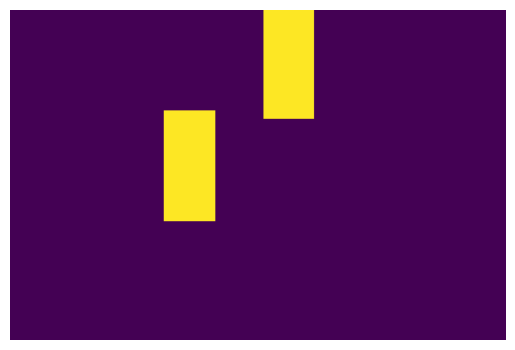

In [6]:
idx = 10

forged_paths = glob(os.path.join(forged_folder, '*.png'))
forged_img = Image.open(forged_paths[idx]).convert('RGB')

img_name = forged_paths[idx].split(os.sep)[-1]

auth_path = os.path.join(authentic_folder, f'{img_name}')
auth_img = Image.open(auth_path).convert('RGB')

prob_mask = infer_segmentation(img=forged_img)
bool_mask = probability_to_boolean_mask(prob_mask)
# smooth_mask = smooth_boolean_mask_positive(bool_mask, kernel_size=3)
pred_mask = upscale_mask(bool_mask, forged_img, method='linear')

# visualize
plt.imshow(forged_img)
plt.title(f'Forged Image')
plt.axis('off')
plt.show()

# visualize the masks
plt.imshow(auth_img)
plt.title(f'Auth Image')
plt.axis('off')
plt.show()


plt.imshow(pred_mask, cmap='gray')
plt.title(f'Predicted Forged Mask')
plt.axis('off')
plt.show()

forged_img_subtracted = subtract_mask_from_image(forged_img, pred_mask)

plt.imshow(forged_img_subtracted)
plt.axis('off')
plt.show()

extracted_objects = extract_objects(forged_img, pred_mask)

print(f"Extracted {len(extracted_objects)} objects from the forged image.")

results = find_objects_with_sift(extracted_objects, forged_img_subtracted)

print(f"Found {sum(1 for v in results.values() if v is not None)} objects in the forged image using SIFT.")

# Plot bounding boxes
fig, ax = plt.subplots()
ax.imshow(forged_img)

final_masks = collections.defaultdict(list)
for k,v in results.items():
    
    if v is None or k is None or compute_iou(k, v) > IOU_THRESHOLD:
        continue
    
    # Draw key bbox (original) in red
    rect_k = patches.Rectangle((k[0], k[1]), k[2] - k[0], k[3] - k[1], linewidth=2, edgecolor='red', facecolor='none', label='Original')
    ax.add_patch(rect_k)
    
    # Draw value bbox (found) in blue
    rect_v = patches.Rectangle((v[0], v[1]), v[2] - v[0], v[3] - v[1], linewidth=2, edgecolor='blue', facecolor='none', label='Found')
    ax.add_patch(rect_v)
    
    final_masks[v].append(k)
    

ax.axis('off')
plt.legend()
plt.show()
        
# Get the size of forged_img
height, width = np.array(forged_img).shape[:2]

# Create to hold the masks
output_masks = []

for key_bbox, value_bboxes in final_masks.items():
    # Create a boolean mask of the same size as forged_img
    mask = np.zeros((height, width), dtype=bool)
    
    # Convert key_bbox to integers and clip to image bounds
    min_x, min_y, max_x, max_y = map(int, key_bbox)
    min_x = max(0, min_x)
    min_y = max(0, min_y)
    max_x = min(width, max_x)
    max_y = min(height, max_y)
    
    # Set values for the key bounding box (only if valid)
    if min_x < max_x and min_y < max_y:
        mask[min_y:max_y, min_x:max_x] = True
    
    # Set values for each value bounding box
    for bbox in value_bboxes:
        min_x, min_y, max_x, max_y = map(int, bbox)
        min_x = max(0, min_x)
        min_y = max(0, min_y)
        max_x = min(width, max_x)
        max_y = min(height, max_y)
        
        if min_x < max_x and min_y < max_y:
            mask[min_y:max_y, min_x:max_x] = True
    
    # Store the mask in the list
    output_masks.append(mask)
    
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

## Evaluation

Extracted 2 objects from the forged image.
Found 2 objects in the forged image using SIFT.


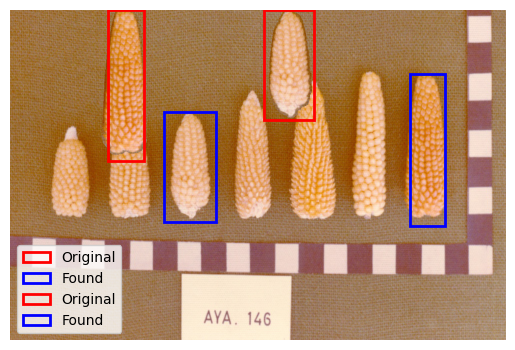

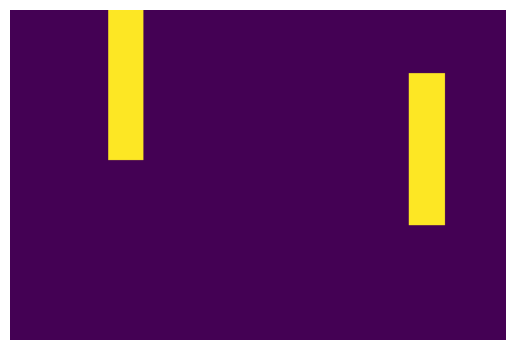

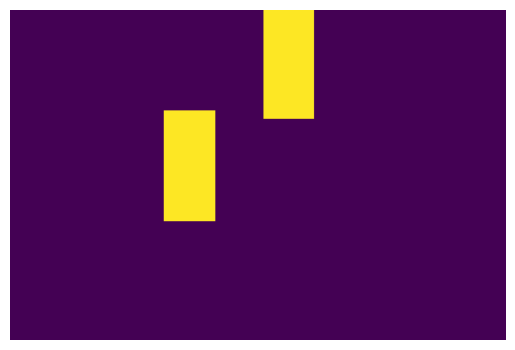

In [40]:
forged_paths = sorted(glob(os.path.join(forged_folder, '*.png')))[:10]

# Add this function before the batch loop
def process_image(idx):
    forged_img = Image.open(forged_paths[idx]).convert('RGB')
    img_name = forged_paths[idx].split(os.sep)[-1].split('.')[0]
    
    prob_mask = infer_segmentation(forged_img)
    bool_mask = probability_to_boolean_mask(prob_mask)
    pred_mask = upscale_mask(bool_mask, forged_img, method='linear')
    
    forged_img_subtracted = subtract_mask_from_image(forged_img, pred_mask)
    
    extracted_objects = extract_objects(forged_img, pred_mask)
    results = find_objects_with_sift(extracted_objects, forged_img_subtracted)
    
    final_masks = collections.defaultdict(list)
    for k, v in results.items():
        if v is None or k is None or compute_iou(k, v) > IOU_THRESHOLD:
            continue
        final_masks[v].append(k)
    
    height, width = np.array(forged_img).shape[:2]
    output_masks = []
    for key_bbox, value_bboxes in final_masks.items():
        mask = np.zeros((height, width), dtype=bool)
        min_x, min_y, max_x, max_y = map(int, key_bbox)
        min_x = max(0, min_x)
        min_y = max(0, min_y)
        max_x = min(width, max_x)
        max_y = min(height, max_y)
        if min_x < max_x and min_y < max_y:
            mask[min_y:max_y, min_x:max_x] = True
        for bbox in value_bboxes:
            min_x, min_y, max_x, max_y = map(int, bbox)
            min_x = max(0, min_x)
            min_y = max(0, min_y)
            max_x = min(width, max_x)
            max_y = min(height, max_y)
            if min_x < max_x and min_y < max_y:
                mask[min_y:max_y, min_x:max_x] = True
        output_masks.append(mask)
    output_mask = np.logical_or.reduce(output_masks) if output_masks else np.zeros((height, width), dtype=bool)
    
    return img_name, output_mask

batch_size = 10  # Adjust as needed
num_images = len(forged_paths)

batch_results = Parallel(n_jobs=-1)(delayed(process_image)(idx) for idx in tqdm(range(len(forged_paths))))
batch_results = {k:v for k,v in batch_results if v is not None}


100%|██████████| 10/10 [00:00<00:00, 1667.45it/s]


10030


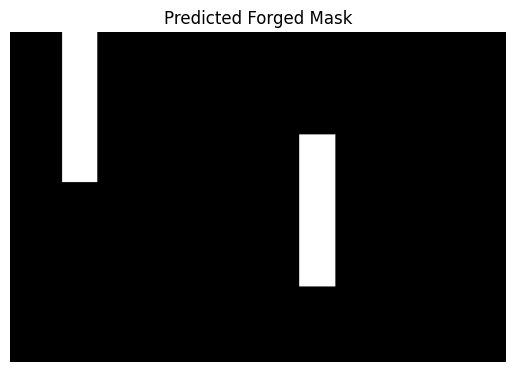

In [41]:
print("10030")
plt.imshow(batch_results["10030"], cmap='gray')
plt.title(f'Predicted Forged Mask')
plt.axis('off')
plt.show()

In [43]:
def process_gt_mask(img_name):
    mask_path = os.path.join(mask_folder, f'{img_name}.npy')
    if not os.path.exists(mask_path):
        return img_name, None
    gt_mask = np.load(mask_path)  # Assume shape (num_instances, H, W) or (H, W)
    if gt_mask.ndim == 3:
        gt_mask = np.logical_or.reduce(gt_mask, axis=0)  # Reduce to (H, W)
        
    # plt.imshow(gt_mask, cmap='gray')
    # plt.title(f'Predicted Forged Mask')
    # plt.axis('off')
    # plt.show()
    
    # Convert to bounding box masks: find connected components and create binary masks for each
    labeled_mask, num_features = label(gt_mask)
    output_masks = []
    for i in range(1, num_features + 1):
        component_mask = (labeled_mask == i)
        output_masks.append(component_mask)
    # Create one output_mask with boolean bounding boxes (union of all component masks)
    if output_masks:
        output_mask = np.logical_or.reduce(output_masks)
    else:
        output_mask = np.zeros_like(gt_mask, dtype=bool)
    
    # plt.imshow(output_mask, cmap='gray')
    # plt.title(f'Predicted Forged Mask')
    # plt.axis('off')
    # plt.show()    
        
    return img_name, output_mask

# Run in parallel
gt_results = Parallel(n_jobs=-1)(delayed(process_gt_mask)(name) for name in tqdm(batch_results.keys()))
gt_results = {k:v for k,v in gt_results if v is not None}



100%|██████████| 10/10 [00:00<00:00, 2961.87it/s]


['10030']


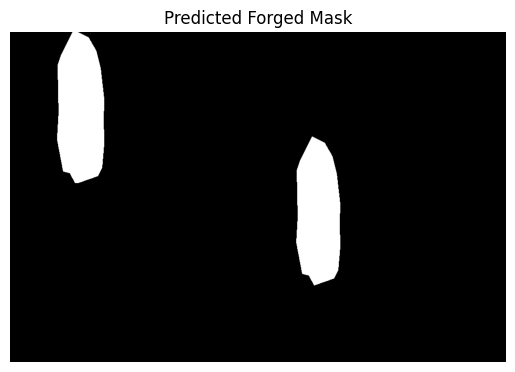

In [45]:
print(["10030"])
plt.imshow(gt_results["10030"], cmap='gray')
plt.title(f'Predicted Forged Mask')
plt.axis('off')
plt.show()

In [49]:
def calculate_iou_mask(pred_mask, gt_mask):
    """
    Calculate IoU between two binary masks.
    
    Args:
        pred_mask: numpy array (H, W) boolean
        gt_mask: numpy array (H, W) boolean
        
    Returns:
        iou: float
    """
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    intersection = np.sum((pred_flat == 1) & (gt_flat == 1))
    union = np.sum((pred_flat == 1) | (gt_flat == 1))
    return intersection / union if union > 0 else 0

def calculate_map(pred_results, gt_results, iou_thresholds=np.arange(0.3, 1.0, 0.05)):
    ap_per_threshold = {}
    
    for iou_thresh in iou_thresholds:
        precisions = []
        
        for k in pred_results.keys():
            if k not in gt_results:
                continue
                
            iou = calculate_iou_mask(pred_results[k], gt_results[k])
            
            # True positive if IoU >= threshold
            tp = 1 if iou >= iou_thresh else 0
            fp = 1 - tp
            
            # Precision for this image
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            precisions.append(precision)
        
        # Average Precision at this threshold
        ap = np.mean(precisions) if precisions else 0
        ap_per_threshold[iou_thresh] = ap
    
    # mAP is the mean of APs across all thresholds
    mAP = np.mean(list(ap_per_threshold.values()))
    
    return mAP, ap_per_threshold

# Calculate mAP
mAP, ap_per_threshold = calculate_map(batch_results, gt_results)
print(f"mAP: {mAP:.4f}")
print("\nAverage Precision per IoU threshold:")
for thresh, ap in ap_per_threshold.items():
    print(f"  IoU {thresh:.2f}: AP = {ap:.4f}")

mAP: 0.0714

Average Precision per IoU threshold:
  IoU 0.30: AP = 0.1000
  IoU 0.35: AP = 0.1000
  IoU 0.40: AP = 0.1000
  IoU 0.45: AP = 0.1000
  IoU 0.50: AP = 0.1000
  IoU 0.55: AP = 0.1000
  IoU 0.60: AP = 0.1000
  IoU 0.65: AP = 0.1000
  IoU 0.70: AP = 0.1000
  IoU 0.75: AP = 0.1000
  IoU 0.80: AP = 0.0000
  IoU 0.85: AP = 0.0000
  IoU 0.90: AP = 0.0000
  IoU 0.95: AP = 0.0000
